In [319]:
import pandas as pd
import psycopg2 as pg2
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, roc_curve
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline as Pipeline_imb
import numpy as np



In [320]:
def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_[:-1]:#the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
    return col_name

In [333]:
conn = pg2.connect(user='postgres',  dbname='penny', host='localhost', port='5432', password='password')
df = pd.read_sql ("""Select * from auction_full WHERE bid > 0""", conn)
df_backup = df.copy()

In [334]:
df = df_backup.copy()

In [335]:
df.is_bidomatic0 = df.is_bidomatic0.astype(str)
df.is_bidomatic1 = df.is_bidomatic1.astype(str)
df.is_bidomatic2 = df.is_bidomatic2.astype(str)
df.is_bidomatic3 = df.is_bidomatic3.astype(str)
df["percent_near_bin0"] = df["bids_so_far0"]/(df["cashvalue"]*2.5)
df["percent_near_bin1"] = df["bids_so_far1"]/(df["cashvalue"]*2.5)
df["percent_near_bin2"] = df["bids_so_far2"]/(df["cashvalue"]*2.5)
df["percent_near_bin3"] = df["bids_so_far3"]/(df["cashvalue"]*2.5)
df[df["is_bidomatic0"]==False].streak0 = 0
df[df["is_bidomatic1"]==False].streak1 = 0
df[df["is_bidomatic2"]==False].streak2 = 0
df[df["is_bidomatic3"]==False].streak3 = 0


In [336]:


y = df.pop('is_winner')
X = df
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0) 


In [337]:
#rus = RandomUnderSampler(random_state=0)
#nm1 = NearMiss(version=1)
#X_train_resampled, y_train_resampled = nm1.fit_resample(X_train, y_train)


In [338]:
categorical_features = ['cardtype', 'limited_allowed', 'is_locked', 'is_bidomatic', 'is_bidomatic0', 'is_bidomatic1', 'is_bidomatic2', 'is_bidomatic3' ]
numeric_features = ['cashvalue','bidvalue', 'prevusers', 
                     'bids_so_far0', 'streak0', 'percent_near_bin0',
                    'distance1', 'bids_so_far1', 'streak1', 'percent_near_bin1',
                    'distance2', 'bids_so_far2', 'streak2', 'percent_near_bin2',
                    'distance3', 'bids_so_far3', 'streak3', 'percent_near_bin3',]
numeric_transformer = Pipeline_imb(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
])
categorical_transformer = Pipeline_imb(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='error', drop='first'))])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
model = Pipeline_imb(steps=[('preprocessor', preprocessor),
                        ('sampler', RandomUnderSampler()),
                      ('classifier', RandomForestClassifier())])


In [339]:
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=-1,
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                             

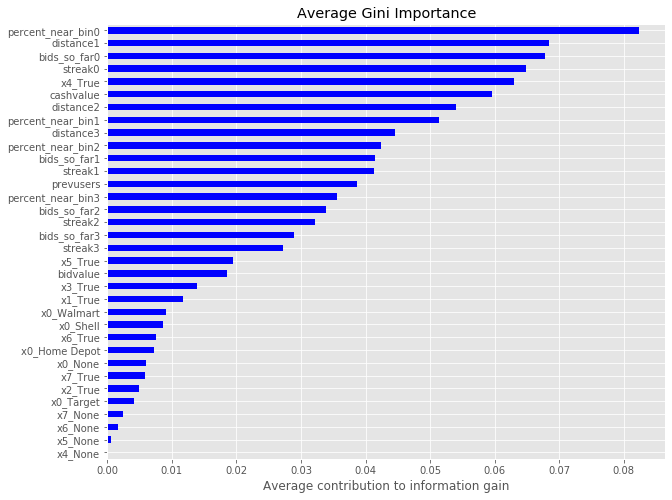

In [340]:
# Plot the feature importance
feat_scores = pd.Series(model.steps[2][1].feature_importances_,
                           index=get_column_names_from_ColumnTransformer(model.named_steps['preprocessor']))
feat_scores = feat_scores.sort_values()
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,8),
                      color='b')
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain');

In [341]:
probs = model.predict_proba(X_test)[:,1]

In [342]:
for thresh in np.arange(.5, 1,  .05):
    y_to_score = probs > thresh
    cm = confusion_matrix(y_test, y_to_score)
    print("*****************************")
    print("thresh:", thresh)
    print ("Accuracy {}: Precision: {}  Recall:{} ".format(accuracy_score(y_test, y_to_score), precision_score(y_test, y_to_score), recall_score(y_test, y_to_score)))
    print(cm)
    profit = sum(X_test.cashvalue[(y_to_score==True)&(y_test==True)])-sum(y_to_score)*.40
    profit_per_bid = profit/len(y_to_score)
    print("profit:", profit)
    print("profit per bid:", profit_per_bid)
    print("*****************************")
    print("")
    


*****************************
thresh: 0.5
Accuracy 0.7287853684041069: Precision: 0.008976810776353053  Recall:0.707432571546222 
[[1019681  379328]
 [   1421    3436]]
profit: -15946.600000000006
profit per bid: -0.011359061334913736
*****************************

*****************************
thresh: 0.55
Accuracy 0.785413992503558: Precision: 0.010348348130061422  Recall:0.6448424953675108 
[[1099484  299525]
 [   1725    3132]]
profit: 800.1999999999971
profit per bid: 0.0005699974214063145
*****************************

*****************************
thresh: 0.6000000000000001
Accuracy 0.8340781812509172: Precision: 0.011815321389584537  Recall:0.5682520074119827 
[[1168174  230835]
 [   2097    2760]]
profit: 9657.0
profit per bid: 0.006878861657736565
*****************************

*****************************
thresh: 0.6500000000000001
Accuracy 0.8762787901409393: Precision: 0.01360951859641036  Recall:0.4863084208359069 
[[1227816  171193]
 [   2495    2362]]
profit: 15301.0
p

(array([ 2., 22., 28., 14., 11.,  5., 13.,  8.,  8.,  4.,  6.,  4.,  0.,
         1.,  4.,  1.,  5.,  2.,  2.,  2.,  2.,  1.,  0.,  0.,  1.,  0.,
         1.,  3.,  0.,  0.,  2.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.]),
 array([  1

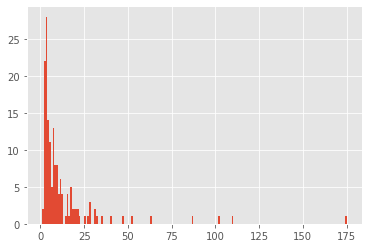

In [343]:
plt.hist(X_test.bid[(y_to_score==True)&(y_test==True)], bins=max(X_test.bid[(y_to_score==True)&(y_test==True)]))

(0, 150)

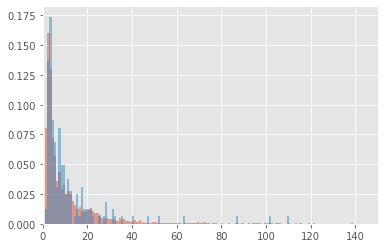

In [352]:
fig, ax = plt.subplots()
ax.hist(X_test.bid[(y_to_score==True)], bins=max(X_test.bid[(y_to_score==True)]), alpha=0.5, density=True)
ax.hist(X_test.bid[(y_to_score==True)&(y_test==True)], bins=max(X_test.bid[(y_to_score==True)&(y_test==True)]), density=True, alpha=.5)
ax.set_xlim(left=0, right=150)